# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Installing surprise library**

In [2]:
!pip install surprise

## **Importing the necessary libraries and overview of the dataset**

In [3]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')


### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [4]:
df_loaded = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Week_7/Project_3/ratings_Electronics.csv')
df_loaded.columns = ['user_id', 'prod_id', 'rating', 'timestamp']
df_loaded.drop('timestamp', axis = 1, inplace = True)
df = df_loaded.copy()

In [5]:
df.head()

,user_id,prod_id,rating
0,A2CX7LUOHB2NDG,0321732944,5.0
1,A2NWSAGRHCP8N5,0439886341,1.0
2,A2WNBOD3WNDNKT,0439886341,3.0
3,A1GI0U4ZRJA8WN,0439886341,1.0
4,A1QGNMC6O1VW39,0511189877,5.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824481 entries, 0 to 7824480
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  object 
 1   prod_id  object 
 2   rating   float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [7]:
df.nunique()

,0
user_id,4201696
prod_id,476001
rating,5


**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [8]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [9]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [10]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [11]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [12]:
# Print a few rows of the imported dataset
df_final.tail()

,user_id,prod_id,rating
7824422,A34BZM6S9L7QI4,B00LGQ6HL8,5.0
7824423,A1G650TTTHEAL5,B00LGQ6HL8,5.0
7824424,A25C2M3QF9G7OQ,B00LGQ6HL8,5.0
7824425,A1E1LEVQ9VQNK,B00LGQ6HL8,5.0
7824426,A2NYK9KWFMJV4Y,B00LGQ6HL8,5.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [13]:
# Check the number of rows and columns and provide observations
df_final.shape

(65290, 3)

After applying these filters
- users who have given at least 50 ratings
- products that have at least 5 ratings

We have a new dataset with **65,290 rows** and **3 columns**

### **Data types**

In [14]:
# Check Data types and provide observations
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65290 entries, 1309 to 7824426
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


**Write your observations here:______**
*    Total number of rows 65,290
*    We have 3 columns user_id, prod_id and rating
*    We have the same total number of values for each column, so no missing information
*    user_id and prod_id are object because those are alphanumeric columns
*    It seems we do not have any null or missing values, we will verify in the next step


### **Checking for missing values**

In [15]:
# Check for missing values present and provide observations
df_final.isnull().sum()

,0
user_id,0
prod_id,0
rating,0


**Write your observations here:______**

As we saw in the info() results and we confirmed with the isnull() .sum() we do not have any missing values on any of these 3 columns.

### **Summary Statistics**

In [16]:
# Summary statistics of 'rating' variable and provide observations
df_final.describe().T

,count,mean,std,min,25%,50%,75%,max
rating,65290.0,4.294808,0.988915,1.0,4.0,5.0,5.0,5.0


**Write your observations here:______**


*   The rating mean is 4.30
*   Standard Deviation of 0.98
*   Min of 1 and Max 5 (as expected)
*   The 25% jumped to 4
*   50% and 75% are 5 which means that the distribution is left skewed



### **Checking the rating distribution**

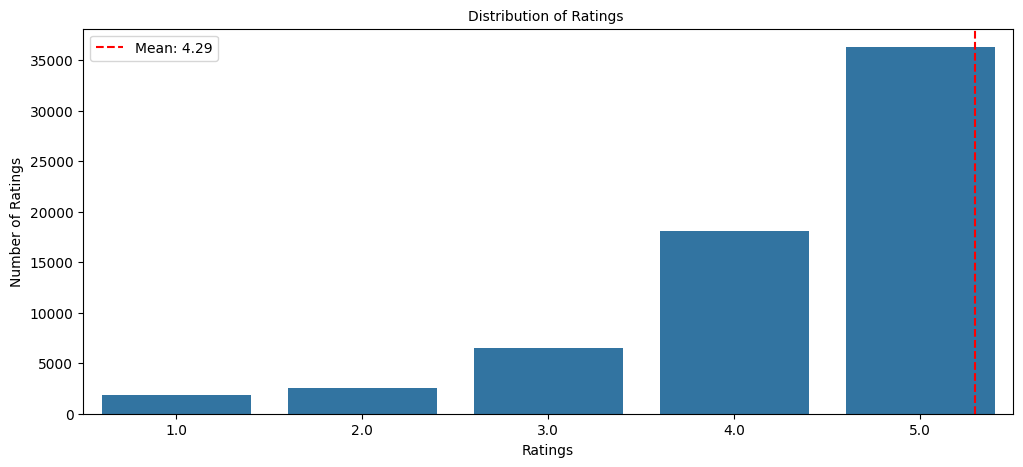

In [17]:
# Create the bar plot and provide observations
plt.figure(figsize = (12, 5))
ax = sns.countplot(x = "rating", data = df_final)
plt.tick_params(labelsize = 10)
plt.title("Distribution of Ratings ", fontsize = 10)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Number of Ratings", fontsize = 10)
mean_rating = df_final['rating'].mean()
plt.axvline(mean_rating, color='red', linestyle='--', label=f'Mean: {mean_rating:.2f}')
plt.legend()
plt.show()

In [18]:
rating_counts = df_final['rating'].value_counts()
rating_percentages = (rating_counts / rating_counts.sum()) * 100
rating_percentage_df = rating_percentages.reset_index()
rating_percentage_df.columns = ['Rating', 'Percentage']
print(rating_percentage_df)

   Rating  Percentage
0     5.0   55.621075
1     4.0   27.763823
2     3.0    9.926482
3     2.0    3.852045
4     1.0    2.836575


**Write your observations here:________**


*   The distribution, as mentioned before, is left skewed
*   The majority of the ratings are 4 and 5
*   The rating 5 has 55% of the total distribution
*   The rating 4 has 27% of the total distribution
*   Since rating 4 and 5 has around 83% of the total distribution, that is the reason why the mean is a high value of 4.29
*   Ratings 1,2 and 3 are only ~17% of the total distribution



### **Checking the number of unique users and items in the dataset**

In [19]:
# Number of total rows in the data and number of unique user id and product id in the data
df_final['user_id'].nunique()

1540

In [20]:
df_final['prod_id'].nunique()

5689

In [21]:
df_final.shape

(65290, 3)

In [22]:
df_final.groupby(['user_id', 'prod_id']).count()['rating'].sum()

65290

 **Write your observations here:_______**

*   There are 1,540 unique users in the dataset
*   There are 5,689 unique products in the dataset
*   The total number of possible ratings between this number of users and product is 1540 * 5689 = 8,761,060.
*    Our dataset has only 65,290 ratings and we confirmed with the groupby user_id, prod_id we have the same number of records, so we can say there is only one interaction between a pair of product and user.
*    We need to create the system to recommend a product to users which they have not bought before



### **Users with the most number of ratings**

In [23]:
# Top 10 users with most ratings provided

user_rating_counts = df_final.groupby('user_id')['rating'].count()
sorted_user_ratings = user_rating_counts.sort_values(ascending=False)
top_10_users = sorted_user_ratings.head(10)
print(top_10_users)


user_id
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A22CW0ZHY3NJH8    193
A1UQBFCERIP7VJ    193
AWPODHOB4GFWL     184
A3LGT6UZL99IW1    179
Name: rating, dtype: int64


**Write your observations here:_______**
*    The top 1 user **ADLVFFE4VBT8** has provided rating to 295 different products
*    The difference between the first and second most active user has a difference of 65 products ~28%
*    The difference of number of products rated by the users from position 5 to 10 is very close of only 17 products of difference

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [24]:
from typing_extensions import final
# Calculate the average rating for each product
average_rating = df_final.groupby('prod_id')['rating'].mean()

# Calculate the count of ratings for each product
count_rating = df_final.groupby('prod_id')['rating'].count()

# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'avg_rating': average_rating, 'rating_count': count_rating})

# Sort the dataframe by average of ratings in the descending order
final_rating = final_rating.sort_values('avg_rating', ascending=False)

# See the first five records of the "final_rating" dataset
final_rating.head(5)

,avg_rating,rating_count
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8


In [25]:
final_rating.rating_count.max()

206

In [26]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_n_products(data, n, min_interaction = 100):
  # Finding products with minimum number of interactions
    recommendations = data[data['rating_count'] > min_interaction]
  # Sorting values with respect to average rating
    recommendations = recommendations.sort_values(by = 'avg_rating', ascending = False)
    return recommendations.index[:n]

### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [27]:
top_5_50_inter = list(top_n_products(final_rating, 5, 50))
for productid in top_5_50_inter:
    print(productid)

B001TH7GUU
B003ES5ZUU
B0019EHU8G
B006W8U2MU
B000QUUFRW


### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [28]:
top_5_100_inter = list(top_n_products(final_rating, 5, 100))
for productid in top_5_100_inter:
    print(productid)

B003ES5ZUU
B000N99BBC
B007WTAJTO
B002V88HFE
B004CLYEDC


We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [29]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [30]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accu = accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

    f1_score = round((2*precision*recall)/(precision+recall), 3)
    return accu, precision, recall, f1_score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [31]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(1,5))

# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id','prod_id','rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [32]:
# Declaring the similarity options
sim_options = {
    'name':'cosine',
    'user_based': True
}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
model1_sim_user_user = KNNBasic(sim_options = sim_options, verbose=False, random_state=1)

# Fit the model on the training data
model1_sim_user_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
model1_rmse, model1_precision, model1_recall, model1_f1score = precision_recall_at_k(model1_sim_user_user)

RMSE: 1.0012
Precision:  0.855
Recall:  0.858
F_1 score:  0.856


In [33]:
models_results = pd.DataFrame(columns = ['Model', 'RMSE', 'Precision', 'Recall', 'F1 Score'])
models_results.loc[len(models_results)] = ['User-User Baseline', model1_rmse, model1_precision, model1_recall, model1_f1score]
predictions_results = pd.DataFrame(columns = ['Model', 'Interaction', 'est'])

In [34]:
models_results.head()

,Model,RMSE,Precision,Recall,F1 Score
0,User-User Baseline,1.001176,0.855,0.858,0.856


**Write your observations here:__________**

*   We got the RMSE that help us to understand how far are the overall predicted ratings from the actual ratings, in this first model we got an RMSE of 1.0012
*   The Precision is ~0.855, this means that out all the recommended products, ~85% are relevant
*   The Recall is ~0.858, this means that out of all the relevant products, 85% are recommended
*   The f1-score is ~.856. It indicates that mostly recommended products were relevant and relevant products where recommended to the user
*   Overall, the performance of this model is very well balanced


Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [35]:
# Predicting rating for a sample user with an interacted product
model1_sim_user_user.predict("A3LDPF5FMB782Z","1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.40   {'actual_k': 5, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.4, details={'actual_k': 5, 'was_impossible': False})

**Write your observations here:__________**

*   The combination user_id/produ_id was found that is why the was_impossible - False
*   The predicted value is 3.40, based on the threshold of 3.5 this product won't be recommended which is an error since the user rated with 5 this product
*   The model is under-estimating the ratings


Below is the **list of users who have not seen the product with product id "1400501466"**.

In [36]:
# Find unique user_id where prod_id is not equal to "1400501466"
def get_users_without_product_interaction(prod_id):
  all_users = df_final['user_id'].unique()
  users_with_product = df_final[df_final['prod_id'] == prod_id]['user_id'].unique()
  users_without_product = [user for user in all_users if user not in users_with_product]
  return users_without_product

In [37]:
print(get_users_without_product_interaction("1400501466"))

['A2ZR3YTMEEIIZ4', 'A3CLWR1UUZT6TG', 'A5JLAU2ARJ0BO', 'A1P4XD7IORSEFN', 'A341HCMGNZCBIT', 'A3HPCRD9RX351S', 'A1DQHS7MOVYYYA', 'ALUNVOQRXOZIA', 'A3G7BEJJCPD6DS', 'A2JXS1JII6SAUD', 'A1C82BC5GNABOA', 'A1VHCO8RQFIGQJ', 'A2Z9S2RQD542CP', 'A2QIC4G483SQQA', 'A3L6L5O89JTX2T', 'A1OGCPMSIVK7G4', 'A18HE80910BTZI', 'A3F9CBHV4OHFBS', 'A1T1YSCDW0PD25', 'ABVYGB2TKBO8F', 'A11ED8O95W2103', 'A3NCIN6TNL0MGA', 'ASHJAZC9OA9NS', 'A105TOJ6LTVMBG', 'A14JBDSWKPKTZA', 'A3QX0ERX4D03TF', 'A13WREJ05GMRA6', 'A3N8O68DOEQ2FE', 'A3J8A5L5AF5TX9', 'A2HRHF83I3NDGT', 'A1R3GN9MEJFXM3', 'A3963R7EPE3A7E', 'A2JOPUWVV0XQJ3', 'AAW7X3GRD8GY9', 'A3V8P0O224OBDB', 'AY6A8KPYCE6B0', 'A212MDP6K4VJS5', 'A28X0LT2100RL1', 'A1V3TRGWOMA8LC', 'A1NZLRAZJGD99W', 'A1522TN5FVJL0Y', 'A3UXW18DP4WSD6', 'A3CW0ZLUO5X2B1', 'A3TBMGNSEQBWIL', 'AEZJTA4KDIWY8', 'A22CW0ZHY3NJH8', 'A2V7EO331SFUF6', 'A3977M5S0GIG5H', 'A1F1A0QQP2XVH5', 'A231WM2Z2JL0U3', 'A2JWF9IG8PJAOA', 'A3LWC833HQIG7J', 'A38RMU1Y5TDP9', 'A3D822N1K2IAQD', 'A33775AIB1A664', 'ARXU3FESTWMJJ', 

In [38]:
# this function will help us to verify if the combination exists in the dataset
def get_combination(df, col1,col2, value1, value2):
  return df[(df[col1]==value1) & (df[col2]==value2)]

In [39]:
get_combination(df_final, 'user_id','prod_id', "A34BZM6S9L7QI4", "1400501466")

,user_id,prod_id,rating


In [40]:
get_combination(df_final, 'user_id','prod_id', "A25C2M3QF9G7OQ", "B00L3YHF6O")

,user_id,prod_id,rating


In [41]:
get_combination(df_final, 'user_id','prod_id', "A1UQBFCERIP7VJ","B00L3YHF6O")

,user_id,prod_id,rating
7824195,A1UQBFCERIP7VJ,B00L3YHF6O,5.0


* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [42]:
# Predicting rating for a sample user with a non interacted product
model1_sim_user_user.predict("A34BZM6S9L7QI4","1400501466", verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

####Additional testing

During the execution of this project, I found that with the user_id and product_id provided in some cases I am getting some messages by the modules of "Not enought neighbors, and those cases the est is the global rating avg that it is not providing good insights for the analysis of the performance of the models.

For that reason, I am running in all my models these 2 additional predictions

user_id A1UQBFCERIP7VJ

*   user_id A1UQBFCERIP7VJ
*   prod_id B00L3YHF6O
*   True Rating 5

And

*   user_id A25C2M3QF9G7OQ
*   prod_id B00L3YHF6O
*   No rated by the user

---



In [43]:
result = model1_sim_user_user.predict( "A1UQBFCERIP7VJ","B00L3YHF6O" , r_ui=5, verbose=True)

user: A1UQBFCERIP7VJ item: B00L3YHF6O r_ui = 5.00   est = 5.00   {'actual_k': 13, 'was_impossible': False}


In [44]:
predictions_results.loc[len(predictions_results)] = ['User-User Baseline', 'Yes',result.est]

In [45]:
result = model1_sim_user_user.predict("A25C2M3QF9G7OQ","B00L3YHF6O",verbose=True)

user: A25C2M3QF9G7OQ item: B00L3YHF6O r_ui = None   est = 5.00   {'actual_k': 13, 'was_impossible': False}


In [46]:
predictions_results.loc[len(predictions_results)] = ['User-User Baseline', 'No',result.est]

**Write your observations here:__________**

*   In this case, we got a reason in the datails with the message "Not Enough neighbors" that means the model didn't have enough neigbhboring users to make a prediction
*   The parameter min_k: minimum number of neighbors to take into account for aggregation. We didn't pass this parameter so it took the default of 1. If there are not enough neighbors, the prediction is set to the global mean of all ratings(1)
*   So, the est value is the global mean of all ratings



(1) Surprise documentation, k-NN inspirted algorithms https://surprise.readthedocs.io/en/stable/knn_inspired.html


### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [47]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40],
              'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }
# Performing 3-fold cross-validation to tune the hyperparameters
model_knn_cv = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the data
model_knn_cv.fit(data)

# Best RMSE score
print(model_knn_cv.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(model_knn_cv.best_params['rmse'])

0.9728717389813704
{'k': 40, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [48]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True}
# Creating an instance of KNNBasic with optimal hyperparameter values
knn_optimized = KNNBasic(sim_options = sim_options, k = 40, min_k = 6, random_state = 1, verbose = False)

# Training the algorithm on the trainset
knn_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k =10
knn_opt_rmse, knn_opt_precision, knn_opt_recall, knn_opt_f1score = precision_recall_at_k(knn_optimized)


RMSE: 0.9526
Precision:  0.847
Recall:  0.894
F_1 score:  0.87


In [49]:
models_results.loc[len(models_results)] = ['user-user optimized', knn_opt_rmse, knn_opt_precision, knn_opt_recall, knn_opt_f1score]

In [50]:
models_results.head()

,Model,RMSE,Precision,Recall,F1 Score
0,User-User Baseline,1.001176,0.855,0.858,0.856
1,user-user optimized,0.952591,0.847,0.894,0.870


**Write your observations here:__________**

*   As we can see compared with the baseline model
  *    RMSE Decreased ~0.05
  *    Precision Decreased ~0.01
  *    Recall increase  ~0.03
  *    F1-score increase ~0.15



### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [51]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
knn_optimized.predict("A3LDPF5FMB782Z","1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [52]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
knn_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

####Additional testing


In [53]:
result = knn_optimized.predict("A1UQBFCERIP7VJ","B00L3YHF6O" , r_ui=5, verbose=True)

user: A1UQBFCERIP7VJ item: B00L3YHF6O r_ui = 5.00   est = 5.00   {'actual_k': 13, 'was_impossible': False}


In [54]:
predictions_results.loc[len(predictions_results)] = ['User-User Optimized', 'Yes',result.est]


In [55]:
result = knn_optimized.predict("A25C2M3QF9G7OQ","B00L3YHF6O" , verbose=True)

user: A25C2M3QF9G7OQ item: B00L3YHF6O r_ui = None   est = 5.00   {'actual_k': 13, 'was_impossible': False}


In [56]:
predictions_results.loc[len(predictions_results)] = ['User-User Optimized', 'No',result.est]


In [57]:
df_final.tail(20)

,user_id,prod_id,rating
7824124,A3R19YKNL641X3,B00L26YDA4,4.0
7824157,A3CW0ZLUO5X2B1,B00L3YHF6O,5.0
7824159,ADLVFFE4VBT8,B00L3YHF6O,5.0
7824162,A3AYSYSLHU26U9,B00L3YHF6O,5.0
7824170,A4WEZJOIZIV4U,B00L3YHF6O,5.0
7824190,A1EVV74UQYVKRY,B00L3YHF6O,5.0
7824191,A2XCCN239AR1XK,B00L3YHF6O,5.0
7824195,A1UQBFCERIP7VJ,B00L3YHF6O,5.0
7824197,AWPODHOB4GFWL,B00L3YHF6O,5.0
7824200,A35Q0RBM3YNQNF,B00L3YHF6O,5.0


In [58]:
knn_optimized.predict("A3R19YKNL641X3","B00L26YDA4", r_ui=4, verbose=True)

user: A3R19YKNL641X3 item: B00L26YDA4 r_ui = 4.00   est = 4.62   {'actual_k': 8, 'was_impossible': False}


Prediction(uid='A3R19YKNL641X3', iid='B00L26YDA4', r_ui=4, est=4.621767734393383, details={'actual_k': 8, 'was_impossible': False})

In [59]:
knn_optimized.predict("A3CW0ZLUO5X2B1", "B00L26YDA4", verbose=True)

user: A3CW0ZLUO5X2B1 item: B00L26YDA4 r_ui = None   est = 4.71   {'actual_k': 7, 'was_impossible': False}


Prediction(uid='A3CW0ZLUO5X2B1', iid='B00L26YDA4', r_ui=None, est=4.714406900501187, details={'actual_k': 7, 'was_impossible': False})

**Write your observations here:**____________


*   With the examples requested, in both cases I got a message "Not enough neigobors", Which means the model didn't have enough neigbhboring users to make a prediction
*   But I search for another combination user_id A3R19YKNL641X3, prod_id B00L26YDA4 the real rating is 4.0 and the model predicted a 4.62. A little bit higher that the true prediction
*   Another case, user_id A3CW0ZLUO5X2B1 and prod_id B00L26YDA4, there is no current rating from this user to this product, and the prediction provided by the model is 4.71
*   Overall, this optimized model is not to far from the baseline model and the results are good



### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [60]:
# 0 is the inner id of the above user
knn_optimized.get_neighbors(0, 5)

[6, 7, 17, 26, 32]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [61]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [62]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
products_recommended = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, knn_optimized)
type(products_recommended)

list

In [63]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
recommendations_df = pd.DataFrame(products_recommended, columns = ['prod_id','predicted_ratings'])
recommendations_df.head()

,prod_id,predicted_ratings
0,B000067RT6,5
1,B000BQ7GW8,5
2,B001TH7GUU,5
3,B005ES0YYA,5
4,B00834SJSK,5


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [64]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': False}

# KNN algorithm is used to find desired similar items. Use random_state=1
item_item_default = KNNBasic(sim_options = sim_options, random_state = 1, verbose = False)

# Train the algorithm on the trainset, and predict ratings for the test set
item_item_default.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
item_def_rmse, item_def_precision, item_def_recall, item_def_f1score = precision_recall_at_k(item_item_default)
models_results.loc[len(models_results)] = ['item-item baseline', item_def_rmse, item_def_precision, item_def_recall, item_def_f1score]

RMSE: 0.9950
Precision:  0.838
Recall:  0.845
F_1 score:  0.841


In [65]:
models_results.head(10)

,Model,RMSE,Precision,Recall,F1 Score
0,User-User Baseline,1.001176,0.855,0.858,0.856
1,user-user optimized,0.952591,0.847,0.894,0.870
2,item-item baseline,0.995023,0.838,0.845,0.841


**Write your observations here:**____________

*   In this item-item baseline model, we can see that the different metrics has a decrease in the performance compared with the user-user optimized model
*   We should try to improve the perfomance of this model using GridSearchCV by tunning some hyperparameters



Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [66]:
# Predicting rating for a sample user with an interacted product
item_item_default.predict('A3LDPF5FMB782Z','1400501466', r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.27   {'actual_k': 22, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.2727272727272725, details={'actual_k': 22, 'was_impossible': False})

**Write your observations here:**____________

*   In this case, the user got enough neighbors to provide a est prediction of 4.27, when the real rating was of 5.
*   The model is understimating the ratings



Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [67]:
# Predicting rating for a sample user with a non interacted product
item_item_default.predict('A34BZM6S9L7QI4','1400501466', verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

####Additional testing


In [68]:
result = item_item_default.predict("A1UQBFCERIP7VJ","B00L3YHF6O" , r_ui=5, verbose=True)

user: A1UQBFCERIP7VJ item: B00L3YHF6O r_ui = 5.00   est = 4.50   {'actual_k': 40, 'was_impossible': False}


In [69]:
predictions_results.loc[len(predictions_results)] = ['Item-Item Baseline', 'Yes',result.est]


In [70]:
result = item_item_default.predict( "A25C2M3QF9G7OQ","B00L3YHF6O" , verbose=True)

user: A25C2M3QF9G7OQ item: B00L3YHF6O r_ui = None   est = 4.60   {'actual_k': 40, 'was_impossible': False}


In [71]:
predictions_results.loc[len(predictions_results)] = ['Item-Item Baseline', 'No',result.est]


**Write your observations here:**____________


*   In this combination user_id and prod_id, the model didn't have enough neigbhboring users to make a prediction
*   In that case, the est prediction is the overall mean of the ratings 4.29



### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [72]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30],
              'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
item_cv = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the data
item_cv.fit(data)

# Find the best RMSE score
print(item_cv.best_score['rmse'])

# Find the combination of parameters that gave the best RMSE score
print(item_cv.best_params['rmse'])

0.9755189479418425
{'k': 30, 'min_k': 9, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [73]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'msd',
               'user_based': False}

# Creating an instance of KNNBasic with optimal hyperparameter values
item_item_optimized = KNNBasic(sim_options = sim_options, k = 30, min_k = 6, random_state = 1, verbose = False)

# Training the algorithm on the trainset
item_item_optimized.fit(trainset)

# Let us compute precision@k and recall@k, f1_score and RMSE
item_opt_rmse, item_opt_precision, item_opt_recall, item_opt_f1score = precision_recall_at_k(item_item_optimized)

models_results.loc[len(models_results)] = ['item-item Optimized', item_opt_rmse, item_opt_precision, item_opt_recall, item_opt_f1score]

RMSE: 0.9576
Precision:  0.839
Recall:  0.88
F_1 score:  0.859


In [74]:
models_results.head(10)

,Model,RMSE,Precision,Recall,F1 Score
0,User-User Baseline,1.001176,0.855,0.858,0.856
1,user-user optimized,0.952591,0.847,0.894,0.870
2,item-item baseline,0.995023,0.838,0.845,0.841
3,item-item Optimized,0.957582,0.839,0.880,0.859


**Write your observations here:__________**

*   The performance of the model Item-Item optimized compared with the Item-Item baseline is not too different, overall both models are similar
*   item Item optimized had a sligthly improvement



### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [75]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
item_item_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.67   {'actual_k': 22, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.67427701674277, details={'actual_k': 22, 'was_impossible': False})

In [76]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
item_item_optimized.predict("A34BZM6S9L7QI4","1400501466", verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

####Additional testing


In [77]:
result = item_item_optimized.predict( "A1UQBFCERIP7VJ","B00L3YHF6O" , r_ui=5, verbose=True)

user: A1UQBFCERIP7VJ item: B00L3YHF6O r_ui = 5.00   est = 5.00   {'actual_k': 30, 'was_impossible': False}


In [78]:
predictions_results.loc[len(predictions_results)] = ['Item-Item Optimized', 'Yes',result.est]


In [79]:
result = item_item_optimized.predict( "A25C2M3QF9G7OQ","B00L3YHF6O" , verbose=True)


user: A25C2M3QF9G7OQ item: B00L3YHF6O r_ui = None   est = 4.77   {'actual_k': 30, 'was_impossible': False}


In [80]:
predictions_results.loc[len(predictions_results)] = ['Item-Item Optimized', 'No',result.est]


**Write your observations here:__________**


*   In the case of the user who provided a 5 rating to the product
  *   The baseline model did a est = 4.27
  *   The optimized model did a est = 4.67
  *   The estimation was better than the basemodel, but still under estimating the ratings
*   In the case where the user didn't rated the product before
  *   The baseline mode did a est = 4.29 (Not enought neighbors)
  *   The optimized model did a est = 4.29 (Not enough neighbors)
  *   Both models didn't have enough neigbhboring users to make a prediction



### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [81]:
item_item_optimized.get_neighbors(0,5)

[29, 53, 67, 106, 151]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [82]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
item_opt_recommendations = get_recommendations(df_final, "A1A5KUIIIHFF4U", 5, item_item_optimized)

In [83]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
recommendations_item_df = pd.DataFrame(item_opt_recommendations, columns = ['prod_id','predicted_ratings'])
recommendations_item_df.head()

,prod_id,predicted_ratings
0,1400532655,4.292024
1,1400599997,4.292024
2,9983891212,4.292024
3,B00000DM9W,4.292024
4,B00000J1V5,4.292024


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [84]:
# Using SVD matrix factorization. Use random_state = 1
svd_base = SVD(random_state=1)

# Training the algorithm on the trainset
svd_base.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
svd_base_rmse, svd_base_precision, svd_base_recall, svd_base_f1score = precision_recall_at_k(svd_base)

models_results.loc[len(models_results)] = ['SVD baseline', svd_base_rmse, svd_base_precision, svd_base_recall, svd_base_f1score]

RMSE: 0.8882
Precision:  0.853
Recall:  0.88
F_1 score:  0.866


In [85]:
models_results.head(10)

,Model,RMSE,Precision,Recall,F1 Score
0,User-User Baseline,1.001176,0.855,0.858,0.856
1,user-user optimized,0.952591,0.847,0.894,0.870
2,item-item baseline,0.995023,0.838,0.845,0.841
3,item-item Optimized,0.957582,0.839,0.880,0.859
4,SVD baseline,0.888217,0.853,0.880,0.866


**Write your observations here:___________**


*   SVD is providing the lower RMSE of all the models we have ran so far
*   Precision and Recall percentages increased
*   F1-Score also increased compared with the previous models, but the model user-user optimized was a little bit higher (minimal)



**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [86]:
# Making prediction
svd_base.predict("A3LDPF5FMB782Z", "1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.08   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.081406749810685, details={'was_impossible': False})

**Write your observations here:___________**


*   The model was able to predict the est with a value of 4.08 compared with the real rating of 5 is still understimating the ratings
*   The est value is lower than previous models even when the performance of the model seems to be higher




**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [87]:
# Making prediction
svd_base.predict("A34BZM6S9L7QI4","1400501466", verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.40   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.40037568046934, details={'was_impossible': False})

####Additional testing


In [88]:
result = svd_base.predict( "A1UQBFCERIP7VJ","B00L3YHF6O" , r_ui=5, verbose=True)

user: A1UQBFCERIP7VJ item: B00L3YHF6O r_ui = 5.00   est = 4.82   {'was_impossible': False}


In [89]:
predictions_results.loc[len(predictions_results)] = ['SVD Baseline', 'Yes',result.est]


In [90]:
result = svd_base.predict( "A25C2M3QF9G7OQ","B00L3YHF6O" , verbose=True)


user: A25C2M3QF9G7OQ item: B00L3YHF6O r_ui = None   est = 5.00   {'was_impossible': False}


In [91]:
predictions_results.loc[len(predictions_results)] = ['SVD Baseline', 'No',result.est]


**Write your observations here:___________**

*   In this case, the model predicted a est of 4.40
*   The model was able to provide a est, compared with other models where the result was the global mean of the rating due to the not enough neighbors message



### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [92]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30],
              'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross-validation
svd_cv = GridSearchCV(SVD, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting data
svd_cv.fit(data)

# Best RMSE score
print(svd_cv.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(svd_cv.best_params['rmse'])

0.8983362084013221
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [93]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
svd_optimized = SVD(n_epochs = 30, lr_all = 0.01, reg_all = 0.2, random_state = 1)

# Train the algorithm on the trainset
svd_optimized = svd_optimized.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
svd_opt_rmse, svd_opt_precision, svd_opt_recall, svd_opt_f1score = precision_recall_at_k(svd_optimized)

models_results.loc[len(models_results)] = ['SVD Optimized', svd_opt_rmse, svd_opt_precision, svd_opt_recall, svd_opt_f1score]

RMSE: 0.8814
Precision:  0.853
Recall:  0.874
F_1 score:  0.863


In [94]:
models_results.head(12)

,Model,RMSE,Precision,Recall,F1 Score
0,User-User Baseline,1.001176,0.855,0.858,0.856
1,user-user optimized,0.952591,0.847,0.894,0.870
2,item-item baseline,0.995023,0.838,0.845,0.841
3,item-item Optimized,0.957582,0.839,0.880,0.859
4,SVD baseline,0.888217,0.853,0.880,0.866
5,SVD Optimized,0.881439,0.853,0.874,0.863


**Write your observations here:_____________**

*   Compared with the svd baseline model, I can mention that the variation in the models performance is very similar, it is almost identical.
*   We cannot say, in this case, that the hyperparameters tunning helped in the model performance improvement



### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [95]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.24   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.238900563954771, details={'was_impossible': False})

In [96]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_optimized.predict("A34BZM6S9L7QI4","1400501466", verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.20   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.204418940307481, details={'was_impossible': False})

####Additional testing


In [97]:
result = svd_optimized.predict( "A1UQBFCERIP7VJ","B00L3YHF6O" , r_ui=5, verbose=True)

user: A1UQBFCERIP7VJ item: B00L3YHF6O r_ui = 5.00   est = 4.97   {'was_impossible': False}


In [98]:
predictions_results.loc[len(predictions_results)] = ['SVD Optimized', 'Yes',result.est]


In [99]:
result = svd_optimized.predict( "A25C2M3QF9G7OQ","B00L3YHF6O" , verbose=True)


user: A25C2M3QF9G7OQ item: B00L3YHF6O r_ui = None   est = 4.98   {'was_impossible': False}


In [100]:
predictions_results.loc[len(predictions_results)] = ['SVD Optimized', 'No',result.est]


### **Conclusion and Recommendations**

In [101]:
models_results.head(12)

,Model,RMSE,Precision,Recall,F1 Score
0,User-User Baseline,1.001176,0.855,0.858,0.856
1,user-user optimized,0.952591,0.847,0.894,0.870
2,item-item baseline,0.995023,0.838,0.845,0.841
3,item-item Optimized,0.957582,0.839,0.880,0.859
4,SVD baseline,0.888217,0.853,0.880,0.866
5,SVD Optimized,0.881439,0.853,0.874,0.863


In [102]:
models_results.Precision.mean(), models_results.Recall.mean(), models_results['F1 Score'].mean()

(0.8475, 0.8718333333333333, 0.8591666666666665)

As we can see in the above table, the difference between the different models we tested it is not something considerable. In this case, from my point of view, we should mainly focus on F1 Score with a tendency to have a good precision performance.
What is my rationale about it?
*    Amazon is a E-commerce company, so the sales are an important topic for them as a any other company of this industry.
*    At the same time, as mentioned in the initail context statement, these companies have been doing important investment to get more accurate recommendation models.
*    One of the success of Amazon, is that the recommendations they do are accurate (Precision) but at the same they do not recommend products that are not relevant for the end user (Recall).
*    For that reason, F1-Score should be the main performance metric that we should use to measure the performance of the models we are comparing

**Model's Performance Comparison**

My recommendation is to use the model SVD Baseline which is providing these performance metrics
*    RMSE      = 0.888
*    Precision = 0.853
*    Recall    = 0.880
*    F1-Score  = 0.866

This model showed a good balance results between Precision and Recall, and the F1-Score was the top 2nd compared with the rest of the models.

**Write your conclusion and recommendations here**

In [103]:
predictions_results.head(20)

,Model,Interaction,est
0,User-User Baseline,Yes,5.000000
1,User-User Baseline,No,5.000000
2,User-User Optimized,Yes,5.000000
3,User-User Optimized,No,5.000000
4,Item-Item Baseline,Yes,4.500000
5,Item-Item Baseline,No,4.600000
6,Item-Item Optimized,Yes,5.000000
7,Item-Item Optimized,No,4.766667
8,SVD Baseline,Yes,4.817991
9,SVD Baseline,No,5.000000


In the table above, we can see the different estimations the models did to the same combination of user_id and prod_id.

To clarify, the column called interaction has 2 possible values

- Yes: Which means that in the reduced dataset we found that the user provided a rating for this product
- No: Which means that in the reduced dataset we didn't find a rating provided by the user to the specific product

We used the same combination of users and products to predict the est on each model

In this example we got the following ratings est

*     User who rated the product: 4.82
*     User who dind't rate the product: 5

If we calculate the est mean for the same user/prod combination all the different models, we get

*    User who rated the product: 4.88
*    User who didn't rate the product: 4.89

Our selected model is really close to that mean.

Based on the dataset we got, the filtering we apply to it and the skewed of the ratings, we can consider that this is a good model to recommend product to the Amazon users.

Of course we can continue improving these models

*   We should do more hyperparameters tunning and verify if the overall performance of the differentes models improves
*   We can try building a more comples model like hybrid recommendation systems
*   We should look a diffent way how to apply the filtering to the dataset, looking how to get more truly available relationships user/products that will help the model to learn better from data

One last comment, during this project we got some results from different models about "Not Enough neighbors". Since this is a possible scenario that we can face when releasing this model we need to keep in mind that when this situation happens, the predicted estimation is the global average of the ratings. I recommend apply some log strategy to track and analyze how often this scenario is raised while doing these recommendations.

Another recommendation, Amazon should promote the action to rate products with the end users, some recommended strategies
-   Provide a discounts or coupon code every X amount of times the user rate a product
-   Provide a gift card with 5 USD (for example) to the users everytime they rate a product
-   Rank or provide some kind of badge to the users based ont he number of times they rank products
-   This actions could be very effective and some other e-commerce platforms used them. For example, Best Buy send a 5 USD gift card to be redeem only at the store for each review. This review includes a rating, comments, answers to the questions if the price is good, the quality is good or if the user would recommend this product. This is valueable information for the user and for this kind of recommendation systems

